#Instalações do Ambiente

In [1]:
!pip install psycopg2

In [ ]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 9.4 MB/s eta 0:00:00


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!pip install tabulate

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"


In [ ]:
import psycopg2
import numpy as np
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import sum, first
from pyspark.sql.functions import col



In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Conexão com Redshift e Preparação dos Dados
##Objetivos:
- Usar a ferramenta pyspark
- Preparação dos Dados
- Criar uma tabela para ser treinada por um modelo ensemble

##Tabelas usadas:
- Sales(API do Cliente)
- Concatenação das 4 tabelas CNPJ
- Bacen

## Conectando com Redshift

In [ ]:
host = 'default-workgroup.374171957244.us-east-1.redshift-serverless.amazonaws.com'
port = '5439'
database = 'group5'
user = 'admin'
password = 'Inteli90'

conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

cursor = conn.cursor()

query = 'SELECT * FROM dados_api_parceiro_g05 '

cursor.execute(query)

results = cursor.fetchall()
print(results)

[(12139, 11418228000201, 3, 'Vinho', datetime.datetime(2023, 4, 23, 0, 0), 589.0, 98), (12140, 41326845000159, 7, 'Feijão', datetime.datetime(2023, 4, 23, 0, 0), 591.0, 83), (12141, 20411431000158, 12, 'Pão de Forma', datetime.datetime(2023, 4, 23, 0, 0), 914.0, 70), (12142, 5659670000138, 5, 'Ketchup', datetime.datetime(2023, 4, 23, 0, 0), 986.0, 16), (12143, 38255950000130, 23, 'Tupperware', datetime.datetime(2023, 4, 23, 0, 0), 532.0, 71), (12144, 30710155000182, 20, 'Tênis', datetime.datetime(2023, 4, 23, 0, 0), 107.0, 75), (12145, 44487011000113, 25, 'Sofá', datetime.datetime(2023, 4, 23, 0, 0), 429.0, 16), (12146, 660029000108, 23, 'Tupperware', datetime.datetime(2023, 4, 23, 0, 0), 628.0, 76), (12147, 20513459000104, 8, 'Macarrão', datetime.datetime(2023, 4, 23, 0, 0), 293.0, 56), (12148, 14898846000103, 16, 'Açucar', datetime.datetime(2023, 4, 23, 0, 0), 897.0, 48), (12149, 35883553000114, 3, 'Vinho', datetime.datetime(2023, 4, 23, 0, 0), 117.0, 53), (12150, 26412428000135, 18,

In [ ]:
cnpj1 = spark.read.parquet('/content/drive/Shareddrives/modulo_8/Dados em CSV CNPJ/cnpjs_1.parquet/cnpj1.parquet')

In [ ]:
cnpj1.printSchema()

root
 |-- data: string (nullable = true)
 |-- cnpj: long (nullable = true)
 |-- cnpj_basico: integer (nullable = true)
 |-- cnpj_ordem: integer (nullable = true)
 |-- cnpj_dv: integer (nullable = true)
 |-- identificador_matriz_filial: integer (nullable = true)
 |-- nome_fantasia: string (nullable = true)
 |-- situacao_cadastral: integer (nullable = true)
 |-- data_situacao_cadastral: string (nullable = true)
 |-- motivo_situacao_cadastral: integer (nullable = true)
 |-- nome_cidade_exterior: string (nullable = true)
 |-- id_pais: integer (nullable = true)
 |-- data_inicio_atividade: string (nullable = true)
 |-- cnae_fiscal_principal: integer (nullable = true)
 |-- cnae_fiscal_secundaria: string (nullable = true)
 |-- sigla_uf: string (nullable = true)
 |-- id_municipio: integer (nullable = true)
 |-- id_municipio_rf: integer (nullable = true)
 |-- tipo_logradouro: string (nullable = true)
 |-- logradouro: string (nullable = true)
 |-- numero: string (nullable = true)
 |-- complemento

##Juntando tabelas CNPJ

In [ ]:
cnpj1.createOrReplaceTempView("cnpj1")

In [ ]:
cnpj2 = spark.read.parquet('/content/drive/Shareddrives/modulo_8/Dados em CSV CNPJ/cnpjs_2.parquet/cnpj2.parquet')
cnpj2.createOrReplaceTempView("cnpj2")

In [ ]:
cnpj3= spark.read.parquet('/content/drive/Shareddrives/modulo_8/Dados em CSV CNPJ/cnpjs_3.parquet/cnpj3.parquet')
cnpj3.createOrReplaceTempView("cnpj3")

In [ ]:
cnpj4 = spark.read.parquet('/content/drive/Shareddrives/modulo_8/Dados em CSV CNPJ/cnpjs_4.parquet/cnpj4.parquet')
cnpj4.createOrReplaceTempView("cnpj4")

In [ ]:
tabela = spark.sql('''SELECT * FROM cnpj1
    UNION
    SELECT * FROM cnpj2
    UNION
    SELECT * FROM cnpj3
    UNION
    SELECT * FROM cnpj4''')

In [ ]:
tabela.createOrReplaceTempView("tabela")

## Juntando a união das tabelas CNPJ com a tabelas Sales, a partir da coluna CNPJ

In [ ]:
vendas = spark.read.csv('/content/drive/Shareddrives/modulo_8/api_parceiro/dado_parceiro.csv', header= True, inferSchema = True)
vendas.createOrReplaceTempView("vendas")

In [ ]:
vendas.show()

+---+--------------+----------+-----------------+----------+-----+----------+
| id|          cnpj|idCategory|          produto|      data|preco|quantidade|
+---+--------------+----------+-----------------+----------+-----+----------+
|639| 9245563000114|         1|        Chocolate|2023-10-06|495.0|        49|
|640|37384125000172|        10|     Batata Palha|2023-10-06|946.0|        10|
|641|46084816000141|        17|           Queijo|2023-10-06|906.0|         2|
|642|45727411000111|         1|        Chocolate|2023-10-06|789.0|        67|
|643|43721342000103|        24|            Livro|2023-10-06|240.0|        13|
|644|43708204000194|        26|Jogo de Videogame|2023-10-06|707.0|        61|
|645|34795887000173|        23|       Tupperware|2023-10-06|788.0|        66|
|646|47195448000171|        15|  Papel Higienico|2023-10-06|176.0|        99|
|647|40579374000128|        19|       Ventilador|2023-10-06|938.0|        54|
|648|19065956000108|         2|          Cerveja|2023-10-06|376.

In [ ]:
cnpj_vendas = spark.sql('''
SELECT
    vendas.id,
    vendas.cnpj,
    vendas.idCategory,
    vendas.produto,
    vendas.data,
    vendas.preco,
    vendas.quantidade,
    tabela.sigla_uf
FROM
    vendas
INNER JOIN
    tabela ON vendas.cnpj = tabela.cnpj;
''')

In [ ]:
cnpj_vendas.show()

+-----+--------------+----------+---------------+----------+-----+----------+--------+
|   id|          cnpj|idCategory|        produto|      data|preco|quantidade|sigla_uf|
+-----+--------------+----------+---------------+----------+-----+----------+--------+
|15168| 1174550000190|        22|    Monitor LED|2023-05-23|597.0|        57|      RJ|
|18798|10281023000175|         5|        Ketchup|2023-06-28|748.0|        39|      SP|
| 9659|19687799000164|        10|   Batata Palha|2023-03-30|736.0|        53|      SP|
|10198|31930812000160|        16|         Açucar|2023-04-04|  4.0|         2|      PB|
|25571|32071030000185|         9|Molho de Tomate|2023-09-03| 26.0|        27|      SP|
| 1693|33252035000177|        19|     Ventilador|2023-01-10|325.0|        14|      SP|
| 8567|36508235000136|        14|    Sabão em Pó|2023-03-19|837.0|        76|      RS|
|11568|37030646000121|         4|          Arroz|2023-04-18|599.0|        22|      SP|
|22892|38004256000140|         6|          

In [ ]:
cnpj_vendas.createOrReplaceTempView("cnpj_vendas")

##Juntando o resultado da união com os dados do Bacen, a partir da coluna data

In [ ]:
bacen = spark.read.csv('/content/drive/Shareddrives/modulo_8/dados_financeiros/dados_bacen.csv', header= True, inferSchema = True)

In [ ]:
bacen.show()

+----------+------+----------+-----------------+
|      data|   USD|taxa_selic|taxa_exp_inflacao|
+----------+------+----------+-----------------+
|2000-01-03|1.8003|       0.0|              0.0|
|2000-01-04|1.8329|       0.0|              0.0|
|2000-01-05|1.8536|       0.0|              0.0|
|2000-01-06|1.8453|       0.0|              0.0|
|2000-01-07|1.8273|       0.0|              0.0|
|2000-01-10|1.8153|       0.0|              0.0|
|2000-01-11|1.8211|       0.0|              0.0|
|2000-01-12|1.8306|       0.0|              0.0|
|2000-01-13|1.8185|       0.0|              0.0|
|2000-01-14|1.7989|       0.0|              0.0|
|2000-01-17|1.7949|       0.0|              0.0|
|2000-01-18|1.7916|       0.0|              0.0|
|2000-01-19|1.7976|       0.0|              0.0|
|2000-01-20|1.7793|       0.0|              0.0|
|2000-01-21|1.7776|       0.0|              0.0|
|2000-01-24|1.7644|       0.0|              0.0|
|2000-01-25|1.7733|       0.0|              0.0|
|2000-01-26|1.7761| 

In [ ]:
bacen.createOrReplaceTempView("bacen")

In [ ]:
cnpj_vendas_bacen = spark.sql('''
    SELECT
        cnpj_vendas.id,
        cnpj_vendas.cnpj,
        cnpj_vendas.idCategory,
        cnpj_vendas.produto,
        cnpj_vendas.data,
        cnpj_vendas.preco,
        cnpj_vendas.quantidade,
        cnpj_vendas.sigla_uf,
        bacen.USD,
        bacen.taxa_selic,
        bacen.taxa_exp_inflacao
    FROM
        cnpj_vendas
    INNER JOIN
        bacen ON cnpj_vendas.data = bacen.data;
''')


In [ ]:
cnpj_vendas_bacen.show()

+-----+--------------+----------+---------------+----------+-----+----------+--------+------+----------+-----------------+
|   id|          cnpj|idCategory|        produto|      data|preco|quantidade|sigla_uf|   USD|taxa_selic|taxa_exp_inflacao|
+-----+--------------+----------+---------------+----------+-----+----------+--------+------+----------+-----------------+
|15168| 1174550000190|        22|    Monitor LED|2023-05-23|597.0|        57|      RJ|4.9668|     13.75|              0.0|
|18798|10281023000175|         5|        Ketchup|2023-06-28|748.0|        39|      SP|4.8557|     13.75|              0.0|
| 9659|19687799000164|        10|   Batata Palha|2023-03-30|736.0|        53|      SP|5.1248|     13.75|              0.0|
|10198|31930812000160|        16|         Açucar|2023-04-04|  4.0|         2|      PB|5.0756|     13.75|              0.0|
|25571|32071030000185|         9|Molho de Tomate|2023-09-03| 26.0|        27|      SP|   0.0|     13.25|              0.0|
| 1693|332520350

In [ ]:
cnpj_vendas_bacen.describe().show()

+-------+------------------+--------------------+------------------+-------+----------+-----------------+-----------------+--------+------------------+------------------+--------------------+
|summary|                id|                cnpj|        idCategory|produto|      data|            preco|       quantidade|sigla_uf|               USD|        taxa_selic|   taxa_exp_inflacao|
+-------+------------------+--------------------+------------------+-------+----------+-----------------+-----------------+--------+------------------+------------------+--------------------+
|  count|            407660|              407660|            407660| 407660|    407660|           407660|           407660|  407660|            407660|            407660|              407660|
|   mean|16889.054103910123|3.197254254781573E13|15.500583819849876|   null|      null|498.0594048962371|50.13959426973458|    null|3.4526188895157754|13.311608325565421|0.010268360888976107|
| stddev| 9396.738737538892|1.4053196819

In [ ]:
from pyspark.sql.functions import month, year
cnpj_vendas_bacen = cnpj_vendas_bacen.withColumn('mes', month('data'))

## Utilizando Pandas para Análise e Manipulação mais Simples

In [ ]:
pandas =  cnpj_vendas_bacen.toPandas()

In [ ]:
pandas.duplicated().sum()

375077

In [ ]:
pandas.drop_duplicates(inplace = True)

In [ ]:
pandas.to_csv('/content/drive/Shareddrives/modulo_8/cnpj_vendas_bacen_final.csv')

In [ ]:
pandas.corr()

<ipython-input-37-b00878a1abcb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pandas.corr()


id      cnpj  idCategory     preco  quantidade  \
id                 1.000000  0.007234    0.001256 -0.003666    0.002590   
cnpj               0.007234  1.000000    0.002973  0.006733   -0.006005   
idCategory         0.001256  0.002973    1.000000 -0.003281   -0.004257   
preco             -0.003666  0.006733   -0.003281  1.000000   -0.008167   
quantidade         0.002590 -0.006005   -0.004257 -0.008167    1.000000   
USD               -0.021006 -0.000557   -0.006857 -0.001335   -0.008491   
taxa_selic        -0.399850 -0.004377    0.000094  0.001163   -0.002206   
taxa_exp_inflacao -0.095652 -0.001503    0.011062 -0.010301    0.003810   
mes                0.980713  0.006490    0.001154 -0.001174    0.002345   

                        USD  taxa_selic  taxa_exp_inflacao       mes  
id                -0.021006   -0.399850          -0.095652  0.980713  
cnpj              -0.000557   -0.004377          -0.001503  0.006490  
idCategory        -0.006857    0.000094           0.011062  0.001154  
preco             -0.001335    0.001163          -0.010301 -0.001174  
quantidade        -0.008491   -0.002206           0.003810  0.002345  
USD                1.000000   -0.060170          -0.082966 -0.017675  
taxa_selic        -0.060170    1.000000           0.015705 -0.400977  
taxa_exp_inflacao -0.082966    0.015705           1.000000 -0.088057  
mes               -0.017675   -0.400977          -0.088057  1.000000

In [ ]:
len(pandas)

32583

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/modulo_8/cnpj_vendas_bacen_final.csv')

In [ ]:
df.head()

Unnamed: 0     id            cnpj  idCategory          produto        data  \
0           0  15168   1174550000190          22      Monitor LED  2023-05-23   
1           1  18798  10281023000175           5          Ketchup  2023-06-28   
2           2   9659  19687799000164          10     Batata Palha  2023-03-30   
3           3  10198  31930812000160          16           Açucar  2023-04-04   
4           4  25571  32071030000185           9  Molho de Tomate  2023-09-03   

   preco  quantidade sigla_uf     USD  taxa_selic  taxa_exp_inflacao  mes  
0  597.0          57       RJ  4.9668       13.75                0.0    5  
1  748.0          39       SP  4.8557       13.75                0.0    6  
2  736.0          53       SP  5.1248       13.75                0.0    3  
3    4.0           2       PB  5.0756       13.75                0.0    4  
4   26.0          27       SP  0.0000       13.25                0.0    9

In [ ]:
df = df.drop('Unnamed: 0', axis = 1)

## Tabela que será usada para treino

In [ ]:
df.head()

id            cnpj  idCategory          produto        data  preco  \
0  15168   1174550000190          22      Monitor LED  2023-05-23  597.0   
1  18798  10281023000175           5          Ketchup  2023-06-28  748.0   
2   9659  19687799000164          10     Batata Palha  2023-03-30  736.0   
3  10198  31930812000160          16           Açucar  2023-04-04    4.0   
4  25571  32071030000185           9  Molho de Tomate  2023-09-03   26.0   

   quantidade sigla_uf     USD  taxa_selic  taxa_exp_inflacao  mes  
0          57       RJ  4.9668       13.75                0.0    5  
1          39       SP  4.8557       13.75                0.0    6  
2          53       SP  5.1248       13.75                0.0    3  
3           2       PB  5.0756       13.75                0.0    4  
4          27       SP  0.0000       13.25                0.0    9

## Gráfico de relação preço e quantidade da tabela

<Figure size 1000x800 with 0 Axes>

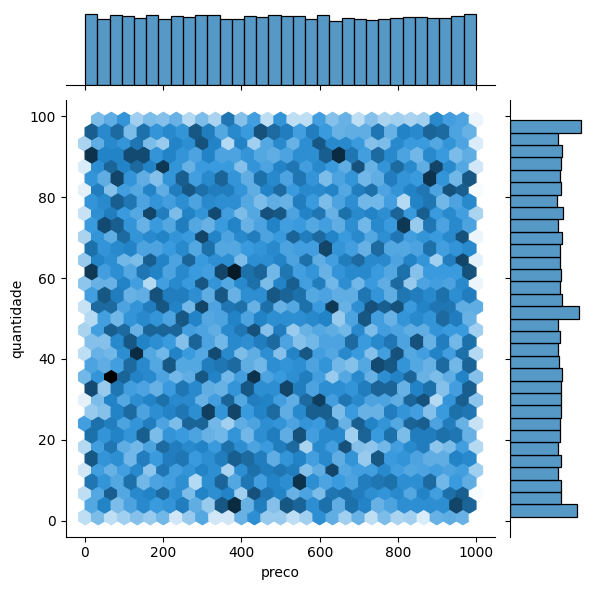

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustar o tamanho da figura
plt.figure(figsize=(10, 8))

# Scatterplot Preço vs. Quantidade com hexbin
sns.jointplot(x='preco', y='quantidade', data=df, kind='hex', gridsize=30)

plt.show()


#Treino do Modelo
##Objetivo:
- Treinar um modelo de Random Forest
- Utilizar as métricas de avaliação
- Descobrir a correlação das Features
- Descobrir a importância das Featuers para o modelo


##Tabela Final, features:
- 'preco', 'idCategory', 'sigla_uf', 'taxa_selic', 'taxa_exp_inflacao', 'USD'


##Objetivo do Modelo
- Prever a demanda (quantidade)


## Explicação do Modelo

O Random Forest é um modelo de aprendizado de máquina pertencente à categoria de Ensemble Learning, comumente utilizado para tarefas de regressão. Enquanto o aprendizado de máquina tradicionalmente envolve a previsão de classes, a regressão com Random Forest visa prever valores numéricos. Durante o treinamento, várias árvores de decisão são construídas de forma aleatória e independente, cada uma utilizando um subconjunto aleatório dos dados e uma seleção aleatória de características. Durante a previsão, os resultados das árvores são combinados, geralmente através de uma média, para produzir uma estimativa mais robusta e precisa do valor desejado. O Random Forest para regressão destaca-se pela sua capacidade de lidar com uma variedade de dados e pela reduzida propensão ao sobreajuste, proporcionando resultados mais confiáveis em comparação com modelos individuais de árvores de decisão.







In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

# Carregar os dados
data = df

# Pré-processamento dos dados
le = LabelEncoder()
data['sigla_uf'] = le.fit_transform(data['sigla_uf'])

# Criar features e target
features = ['preco', 'idCategory', 'sigla_uf', 'taxa_selic', 'taxa_exp_inflacao', 'USD']
target = 'quantidade'

X = data[features]
y = data[target]

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de ensemble (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
predictions = model.predict(X_test)

# Avaliar o modelo
mse_global = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse_global}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2}")

# Pearson correlation coefficient
pearson_corr, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation Coefficient: {pearson_corr}")


Mean Squared Error: 888.5589200041943
Mean Absolute Error (MAE): 25.517789546753182
Root Mean Squared Error (RMSE): 29.808705439924665
R-squared (R²): -0.0972983735755033
Pearson Correlation Coefficient: 0.002658955843739501


## Explicação dos Resultados

Os resultados da avaliação do modelo de regressão Random Forest revelam métricas que indicam o desempenho e a precisão da previsão. O Erro Quadrático Médio (Mean Squared Error) é calculado em 888.5589200041943, o Erro Médio Absoluto (Mean Absolute Error) é de 25.517789546753182, e o Erro Quadrático Médio Raiz (Root Mean Squared Error) é 29.808705439924665. O coeficiente de determinação R² indica a variação explicada pelo modelo, e, neste caso, apresenta um valor muito próximo de zero, sugerindo que o modelo pode não estar capturando efetivamente os padrões nos dados. O Coeficiente de Correlação de Pearson, que mede a relação linear entre as variáveis, é 0.002658955843739501, mostrando que não existe uma relação forte entre as variáveis.

In [ ]:
model.feature_importances_

array([0.38654527, 0.20314574, 0.153606  , 0.04947811, 0.00156894,
       0.20565593])

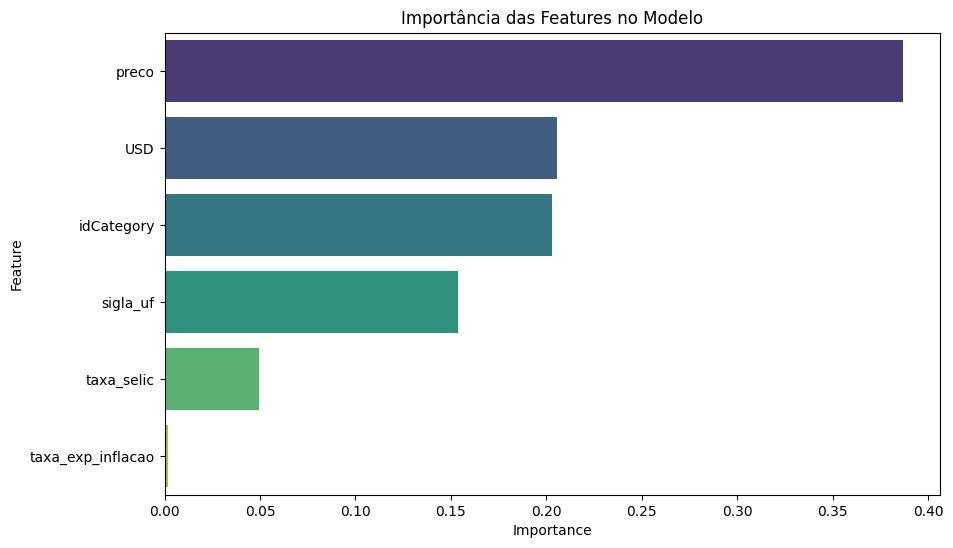

In [ ]:
# Obter a importância das features
feature_importance = model.feature_importances_

# Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Ordenar o DataFrame por importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar a importância das features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importância das Features no Modelo')
plt.show()

## Explicação das importância das features
- preco: É a característica mais importante no modelo.
- USD: Vem em segundo lugar em termos de importância.
- idCategory, sigla_uf, taxa_selic apresentam a mesma relevancia.
- taxa_selic: Não apresenta nenhuma relevância ao modelo

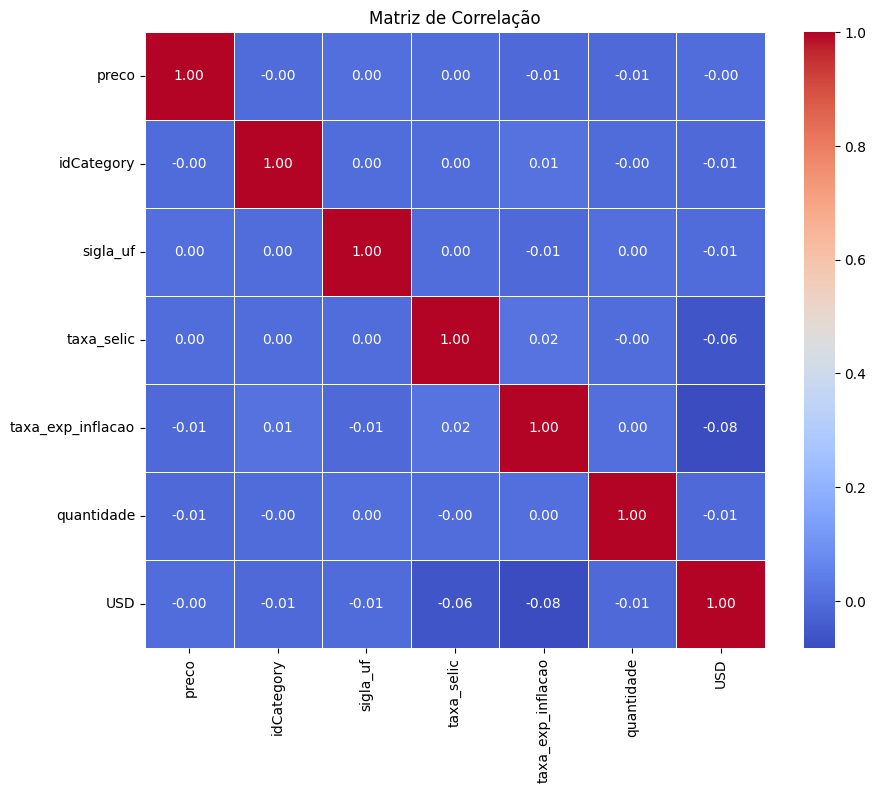

In [ ]:
# Calcular a matriz de correlação
colunas = ['preco', 'idCategory', 'sigla_uf', 'taxa_selic', 'taxa_exp_inflacao', 'quantidade','USD']
correlation_matrix = df[colunas].corr()

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

## Explicação dos resultados dos coeficientes

Preço (preco): O coeficiente é muito próximo de zero, indicando que o preço não está contribuindo significativamente para a variação na quantidade vendida.

Quantidade (quantidade): O coeficiente é muito próximo de 1, o que é esperado, pois é a variável que você está tentando prever.

Categoria do Produto (idCategory): O coeficiente é próximo de zero, sugerindo que a categoria do produto não está tendo um impacto significativo na quantidade vendida.

Sigla UF (sigla_uf): O coeficiente é zero, indicando que a variável não está contribuindo para a variação na quantidade vendida. Isso pode ser devido à codificação ou à falta de variação nos dados.

Taxa Selic (taxa_selic): O coeficiente é próximo de zero, indicando que a taxa Selic não está contribuindo significativamente para a variação na quantidade vendida.

Taxa de Exportação Inflação (taxa_exp_inflacao): O coeficiente é próximo de zero, indicando que a taxa de expectativa de inflação não está contribuindo significativamente para a variação na quantidade vendida.

Dolar (USD): O coeficiente é próximo de zero, indicando que o dolar não está contribuindo significativamente na quantidade vendida.


Conclusão:
Como os dados de venda são fictícios, é normal que não exista relação entre as features

## Possíveis Hiperparâmetros para melhorar o desempenho do modelo
Número de Árvores (n_estimators):

Este parâmetro define quantas árvores de decisão compõem o Random Forest. Aumentar o número de árvores geralmente leva a um modelo mais robusto, mas há um ponto de diminuição dos retornos.
Profundidade Máxima das Árvores (max_depth):

Controla a profundidade máxima de cada árvore de decisão. Ajustar este parâmetro pode ajudar a evitar o sobreajuste (overfitting) ou subajuste (underfitting) do modelo.
Número Mínimo de Amostras para Divisão (min_samples_split):

Define o número mínimo de amostras necessárias para uma divisão em um nó. Ajustar este parâmetro pode influenciar a complexidade das árvores.
Número Mínimo de Amostras em Folhas (min_samples_leaf):

Especifica o número mínimo de amostras permitidas em uma folha. Isso afeta a granularidade das decisões tomadas por cada árvore.
Máximo de Características Consideradas (max_features):

Controla o número máximo de características consideradas para fazer uma divisão em cada nó. Isso pode influenciar a diversidade entre as árvores.
Bootstrap (bootstrap):

Indica se deve ser usado o método de bootstrap (amostragem com substituição) ao construir as árvores. Isso pode afetar a variabilidade entre as árvores.

Além disso, é possível utilizar técnicas de validação cruzada, como o k-fold cross-validation, para avaliar o desempenho do modelo em diferentes conjuntos de dados

# Modelo de Time Series
##Objetivo:
- Treinar um modelo de Time Series
- Conseguir ter uma estimativa da demanda(quantidade no futuro)
- Mostrar outros possíveis modelos para os dados

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61976196 sha256=1a0f10fbdb16986cf60e3fd123bc5d92e728abb657afa44490d70dabefd5644b
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for outp

In [ ]:
!pip install Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/hc52tuk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/whjxlhs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41317', 'data', 'file=/tmp/tmp6e_lqynu/hc52tuk5.json', 'init=/tmp/tmp6e_lqynu/whjxlhs3.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelhwf9j7zc/prophet_model-20231208035713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


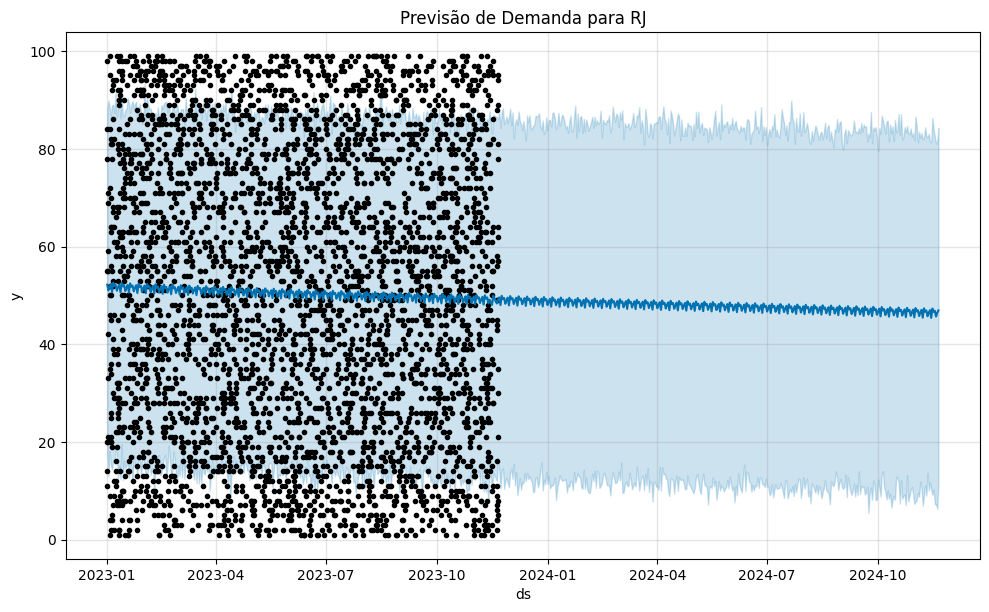

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/6a2cf_w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/nvurpc1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43296', 'data', 'file=/tmp/tmp6e_lqynu/6a2cf_w6.json', 'init=/tmp/tmp6e_lqynu/nvurpc1s.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model6yvfpclh/prophet_model-20231208035715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


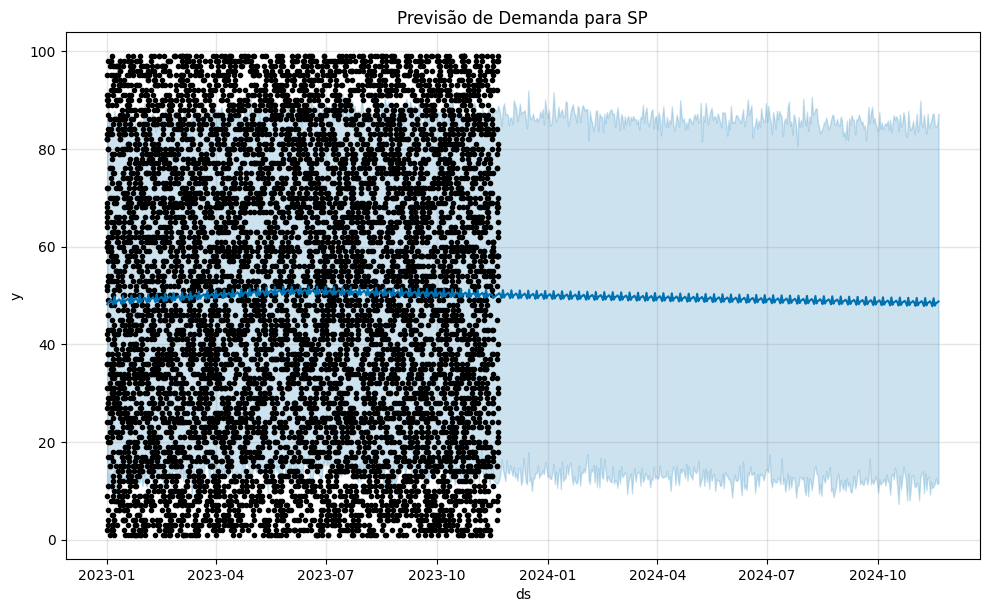

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/1w91corp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/9uw6ddz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60037', 'data', 'file=/tmp/tmp6e_lqynu/1w91corp.json', 'init=/tmp/tmp6e_lqynu/9uw6ddz7.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelu0o07dre/prophet_model-20231208035717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


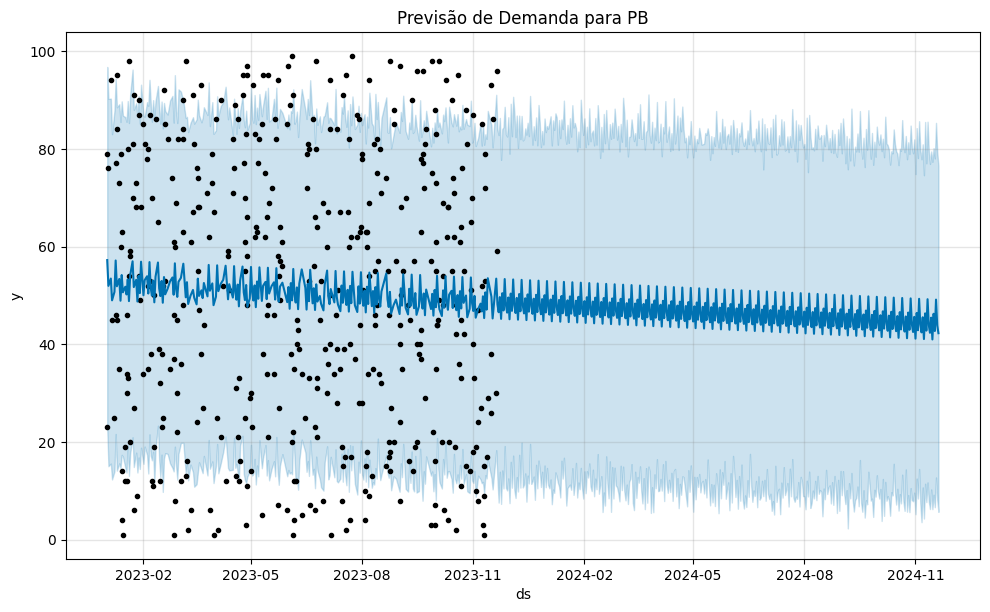

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/kifwklgz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/w3zyfsm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81707', 'data', 'file=/tmp/tmp6e_lqynu/kifwklgz.json', 'init=/tmp/tmp6e_lqynu/w3zyfsm_.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelzsiu7oyb/prophet_model-20231208035718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


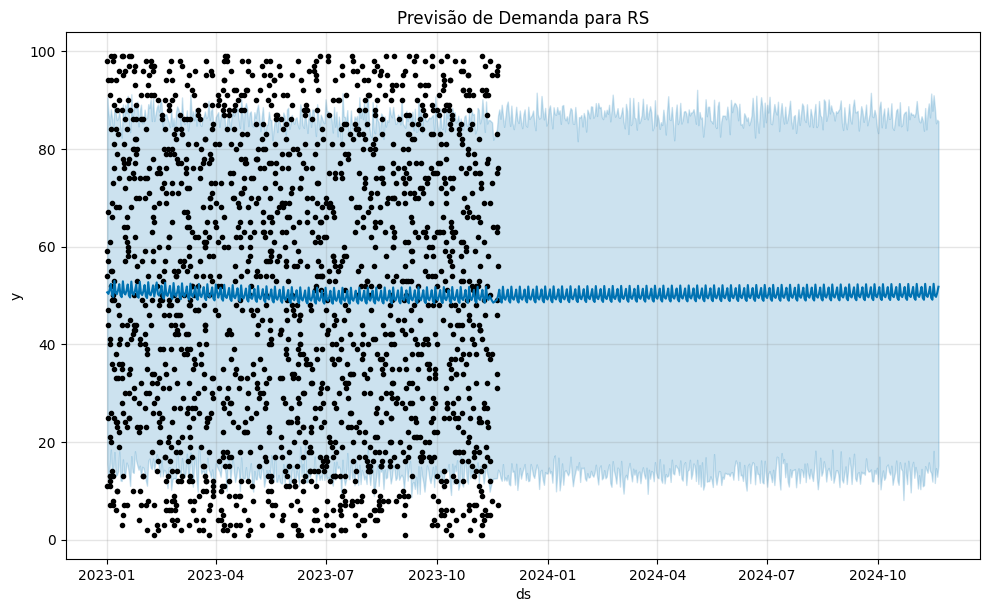

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/50hjoai5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/g_055zvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33608', 'data', 'file=/tmp/tmp6e_lqynu/50hjoai5.json', 'init=/tmp/tmp6e_lqynu/g_055zvc.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model_b7b4ym6/prophet_model-20231208035720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


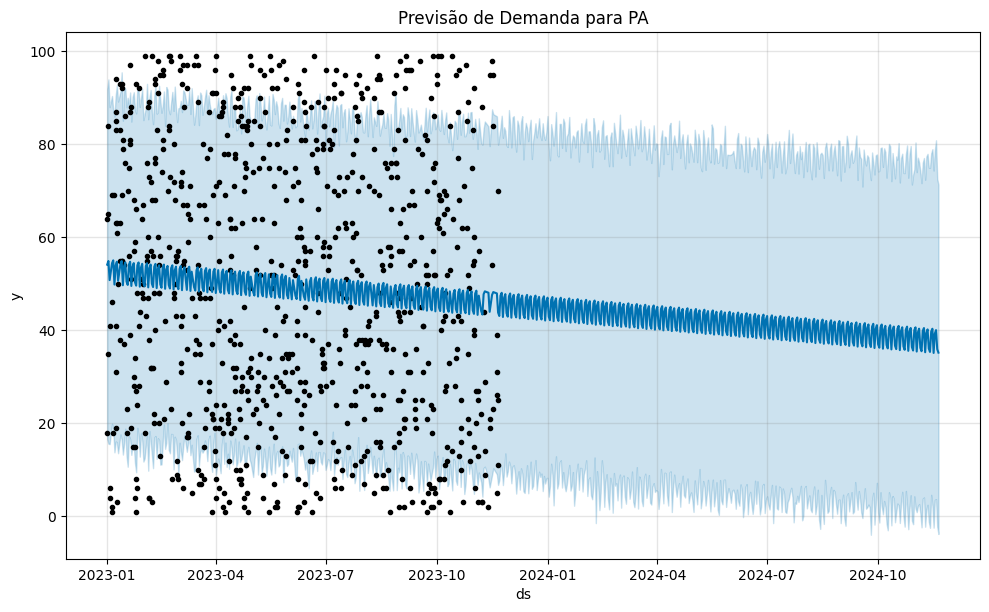

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/_17_64ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/v3pj2mgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80216', 'data', 'file=/tmp/tmp6e_lqynu/_17_64ef.json', 'init=/tmp/tmp6e_lqynu/v3pj2mgo.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model7bsxuhi0/prophet_model-20231208035722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


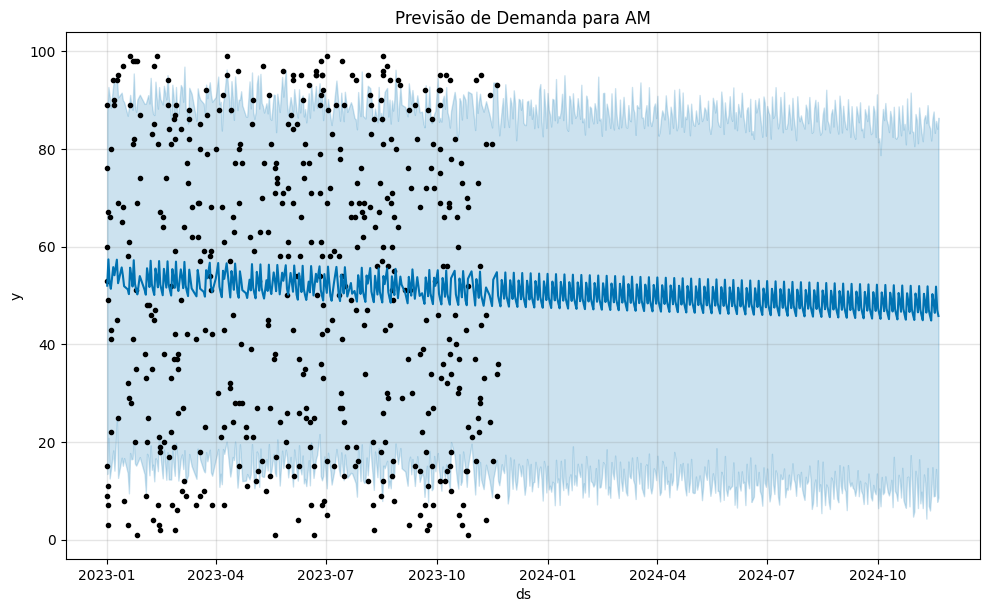

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/j5z8ryl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/m_8h_mul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62105', 'data', 'file=/tmp/tmp6e_lqynu/j5z8ryl3.json', 'init=/tmp/tmp6e_lqynu/m_8h_mul.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelrqp3nntz/prophet_model-20231208035725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


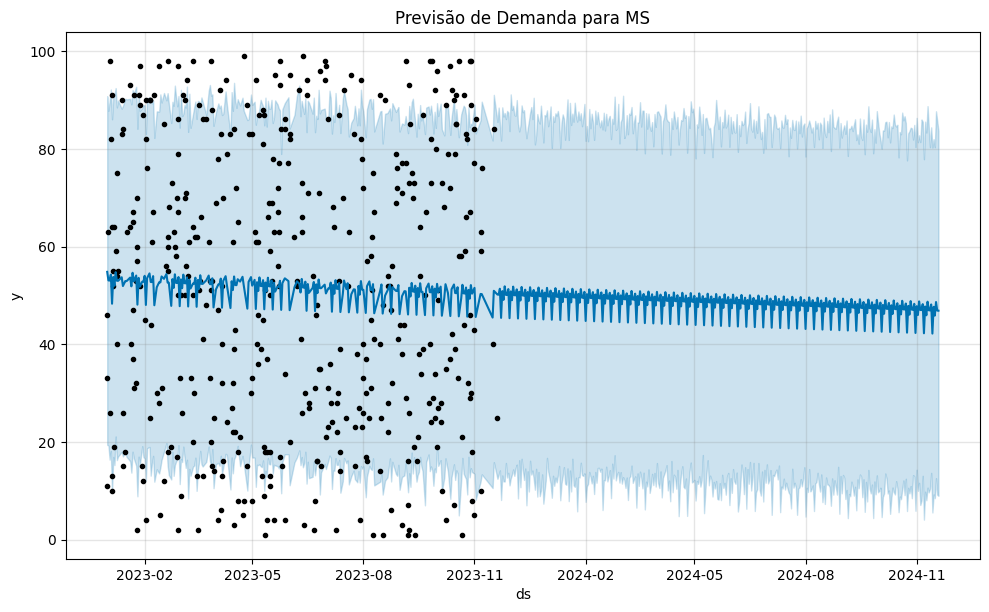

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/v4wr6rva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/57hn1tyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28645', 'data', 'file=/tmp/tmp6e_lqynu/v4wr6rva.json', 'init=/tmp/tmp6e_lqynu/57hn1tyt.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model7acntixo/prophet_model-20231208035729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


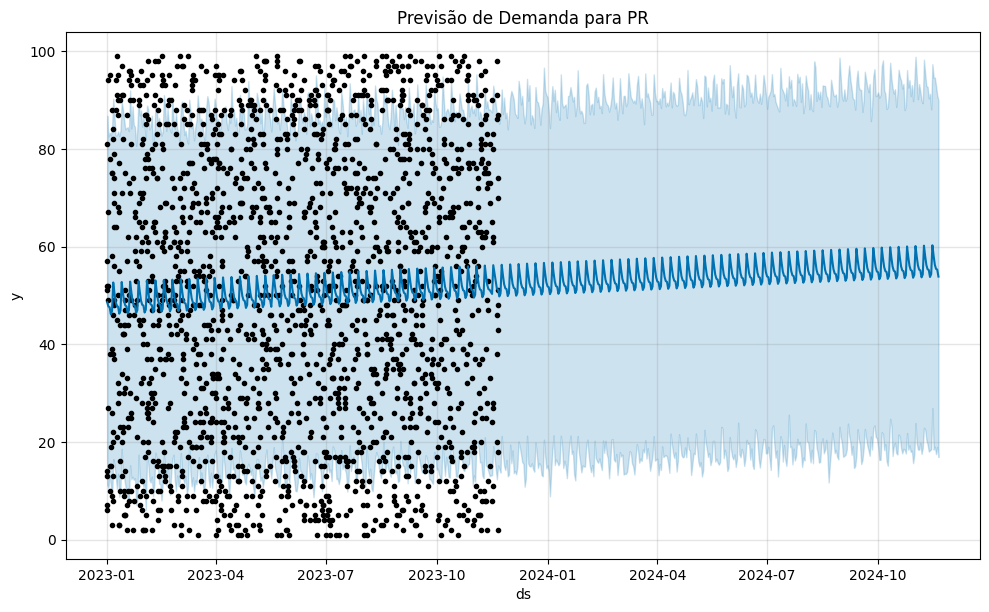

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/x2_r9fgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/au7q_oyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11579', 'data', 'file=/tmp/tmp6e_lqynu/x2_r9fgt.json', 'init=/tmp/tmp6e_lqynu/au7q_oyq.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model8d6479tl/prophet_model-20231208035732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


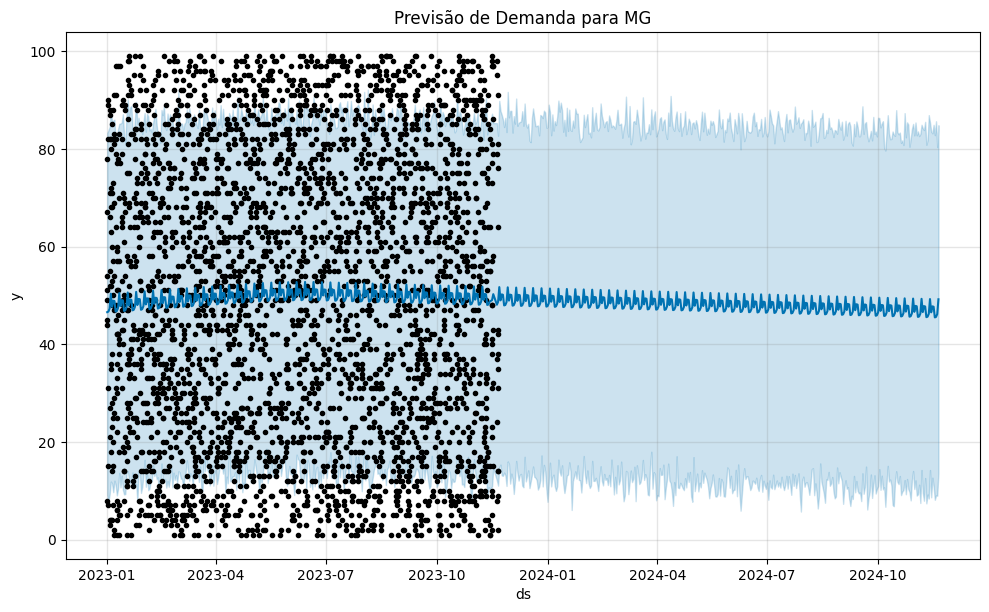

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/_76gngry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/3prc1r69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61429', 'data', 'file=/tmp/tmp6e_lqynu/_76gngry.json', 'init=/tmp/tmp6e_lqynu/3prc1r69.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model5cs3a6dz/prophet_model-20231208035734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


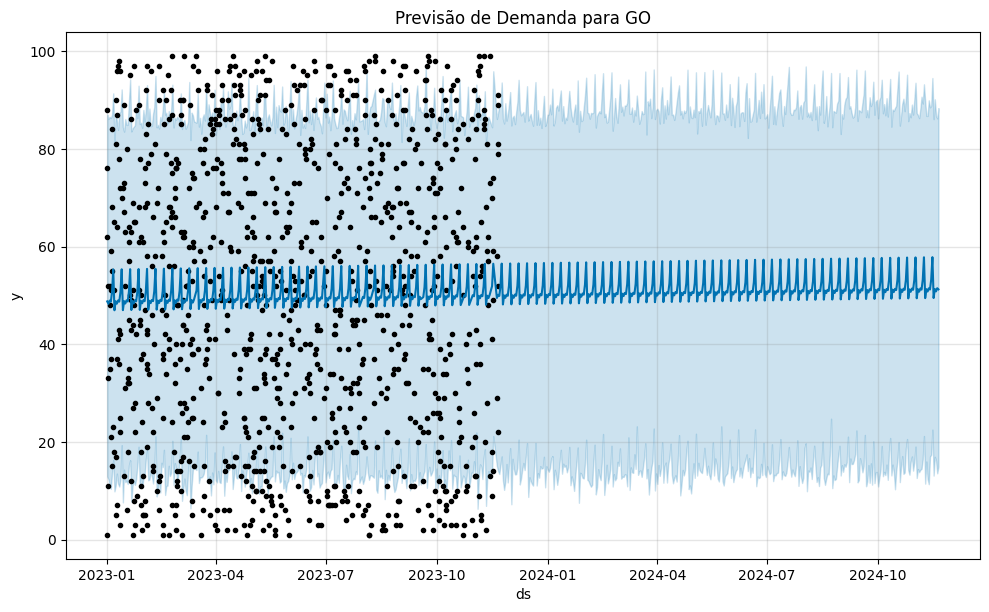

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/h9uzy5ql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/bofnanex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2402', 'data', 'file=/tmp/tmp6e_lqynu/h9uzy5ql.json', 'init=/tmp/tmp6e_lqynu/bofnanex.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modeldh8z30xp/prophet_model-20231208035735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


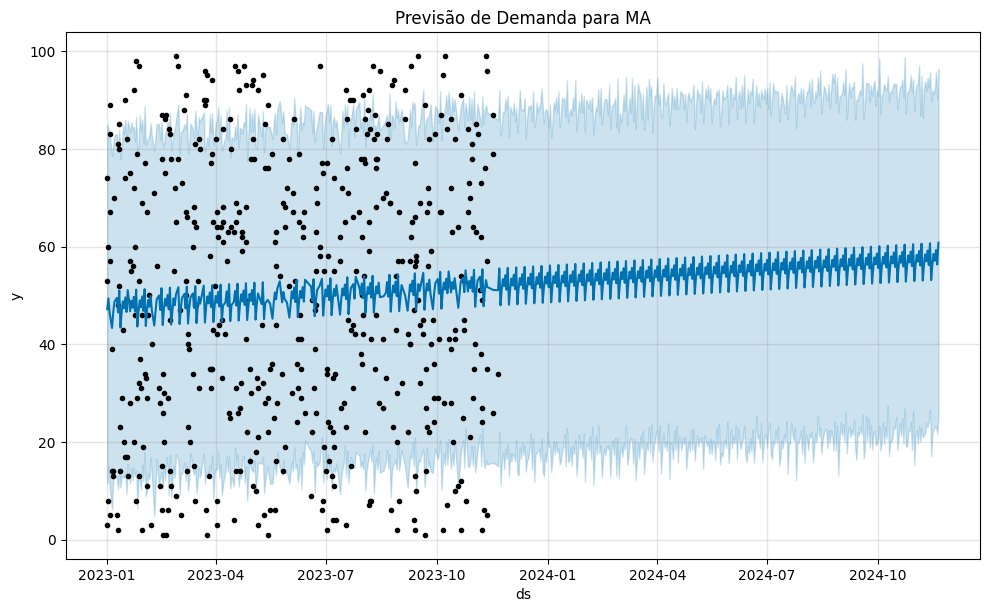

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/3abhuqqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/7r05w3p2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42861', 'data', 'file=/tmp/tmp6e_lqynu/3abhuqqh.json', 'init=/tmp/tmp6e_lqynu/7r05w3p2.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelflleylu0/prophet_model-20231208035737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


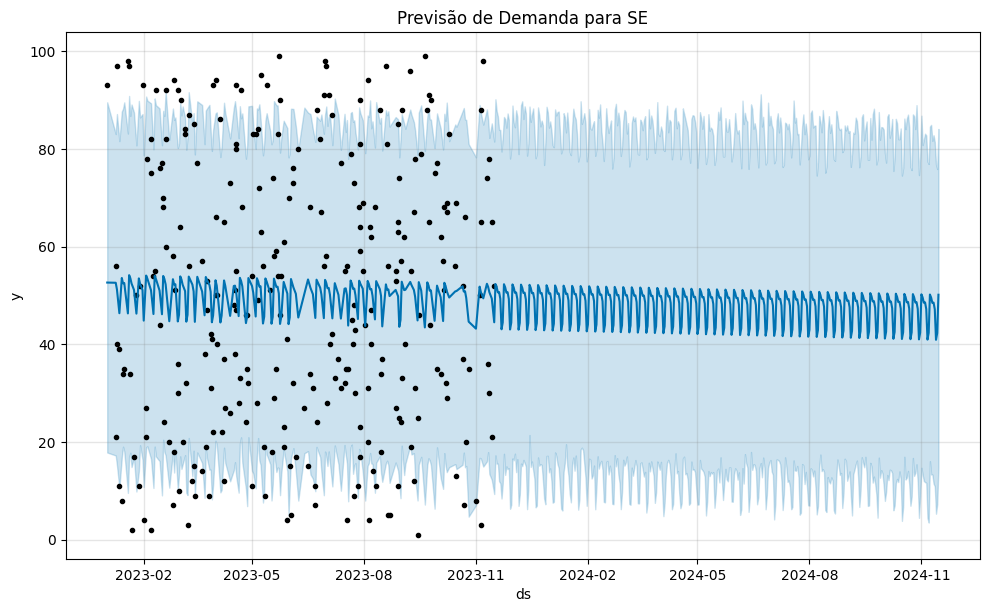

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/54122ofa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/pnnsevtr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82318', 'data', 'file=/tmp/tmp6e_lqynu/54122ofa.json', 'init=/tmp/tmp6e_lqynu/pnnsevtr.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model_3w1vstn/prophet_model-20231208035738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


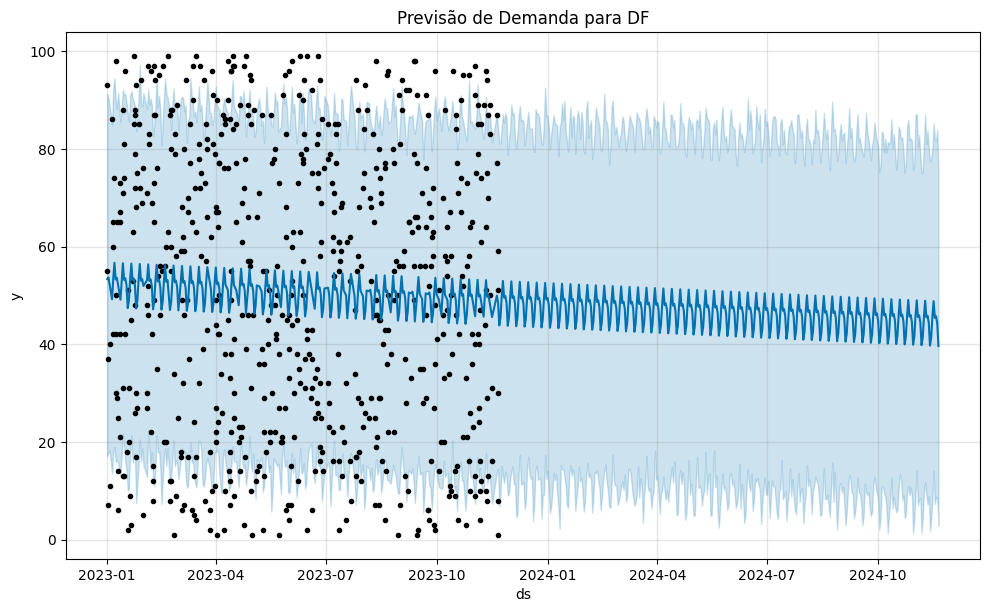

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/yngdf36i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/6_t1nob1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73050', 'data', 'file=/tmp/tmp6e_lqynu/yngdf36i.json', 'init=/tmp/tmp6e_lqynu/6_t1nob1.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelgypyqaje/prophet_model-20231208035740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


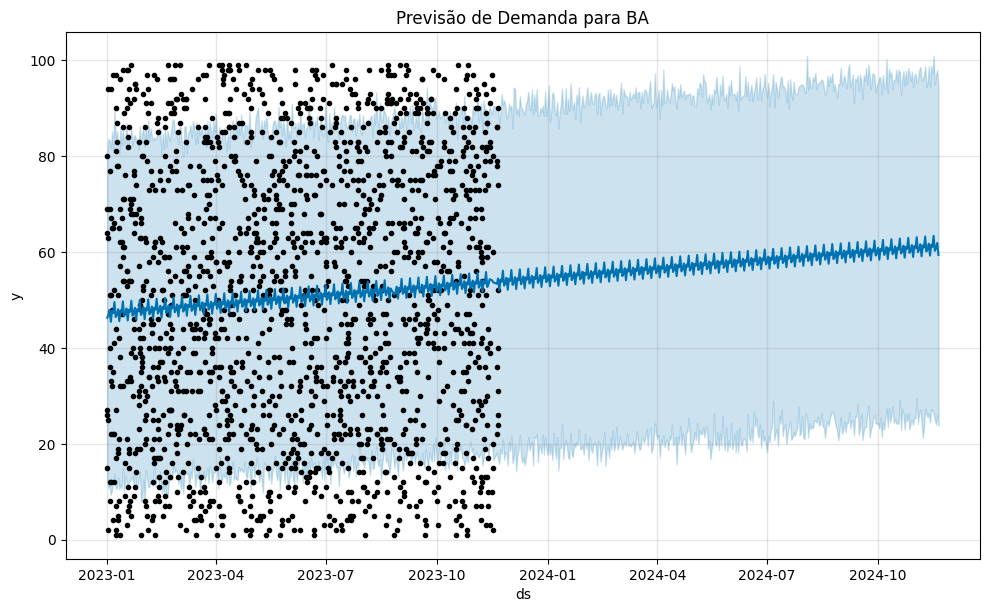

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/8o5dyntu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/gw_l0qjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78074', 'data', 'file=/tmp/tmp6e_lqynu/8o5dyntu.json', 'init=/tmp/tmp6e_lqynu/gw_l0qjs.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model8944m60v/prophet_model-20231208035743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


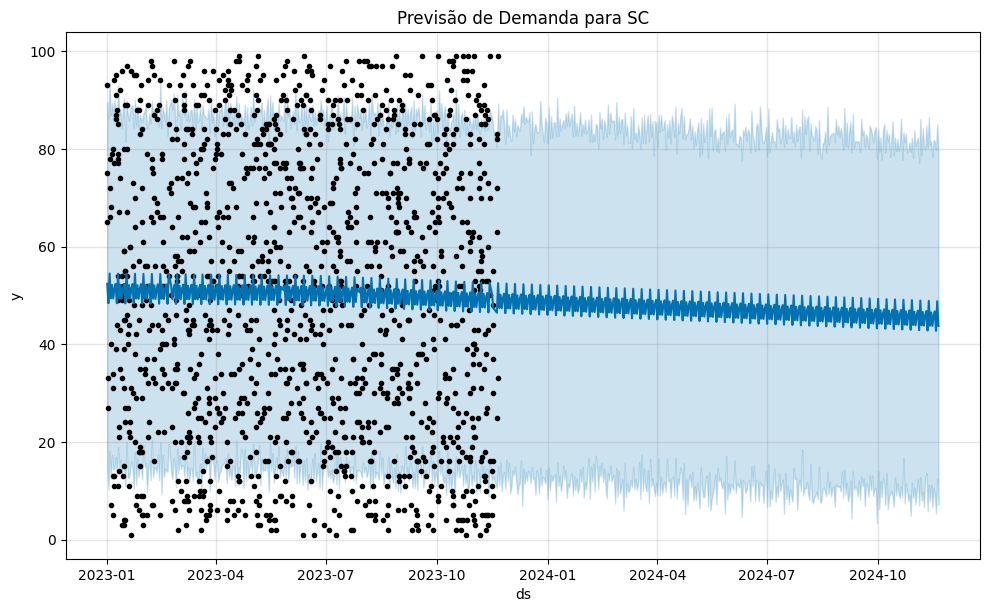

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/xlf339x9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/p_tbpwzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92229', 'data', 'file=/tmp/tmp6e_lqynu/xlf339x9.json', 'init=/tmp/tmp6e_lqynu/p_tbpwzs.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelikhvyqj6/prophet_model-20231208035746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


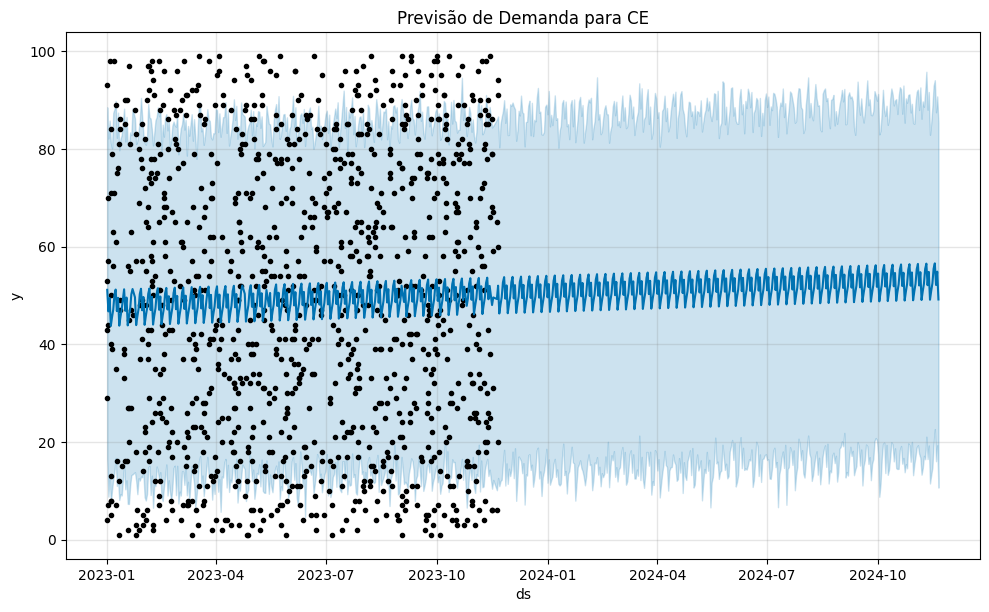

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/u6id33dr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/_v1h1yzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28969', 'data', 'file=/tmp/tmp6e_lqynu/u6id33dr.json', 'init=/tmp/tmp6e_lqynu/_v1h1yzr.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelx4o80krg/prophet_model-20231208035747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


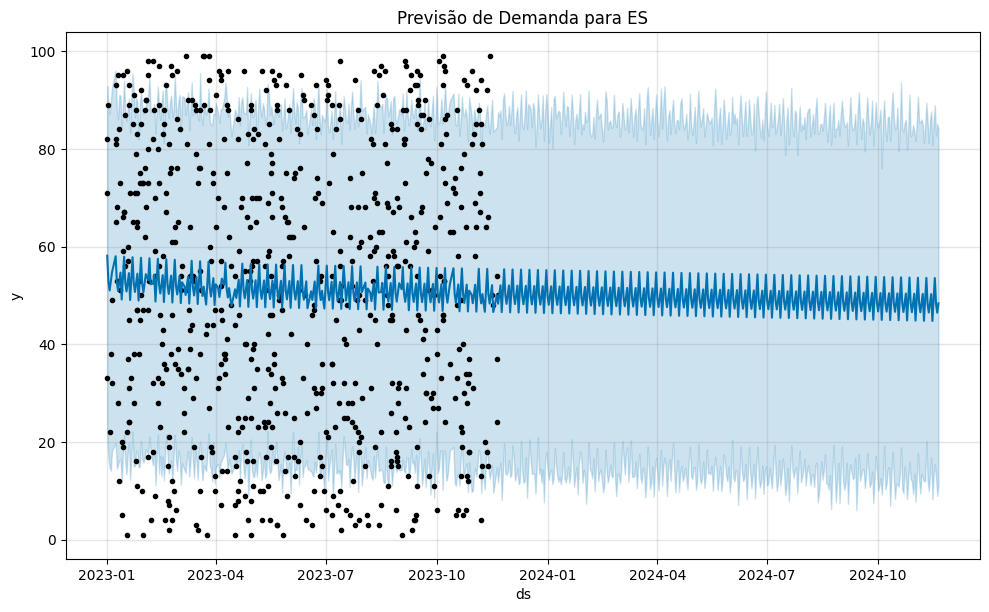

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/d3nqto5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/qqtzxtlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82832', 'data', 'file=/tmp/tmp6e_lqynu/d3nqto5j.json', 'init=/tmp/tmp6e_lqynu/qqtzxtlf.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelgtf15ca3/prophet_model-20231208035748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


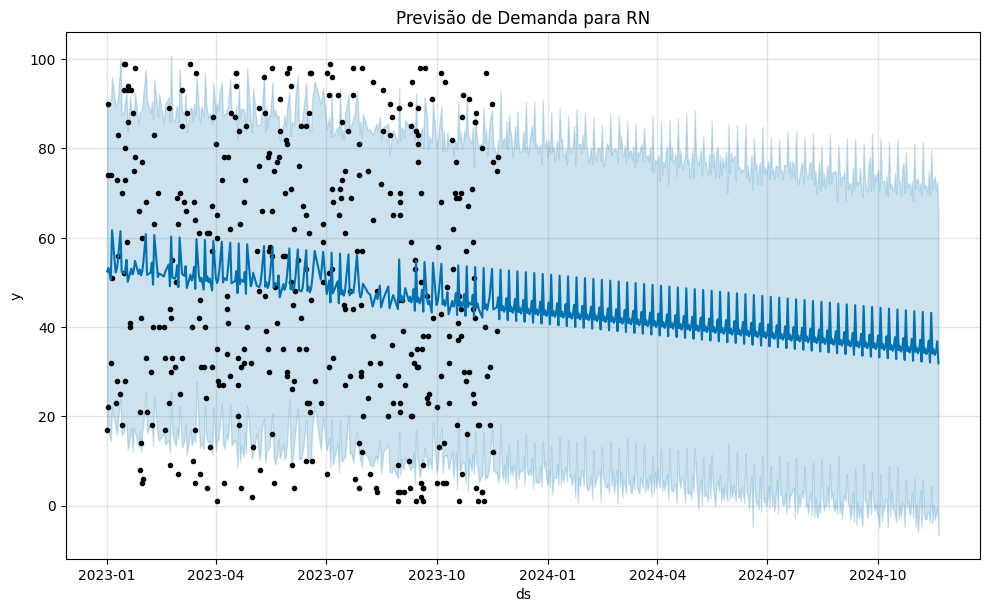

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/yu__olpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/j3aqye2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34484', 'data', 'file=/tmp/tmp6e_lqynu/yu__olpa.json', 'init=/tmp/tmp6e_lqynu/j3aqye2d.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model0m0lacvg/prophet_model-20231208035749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


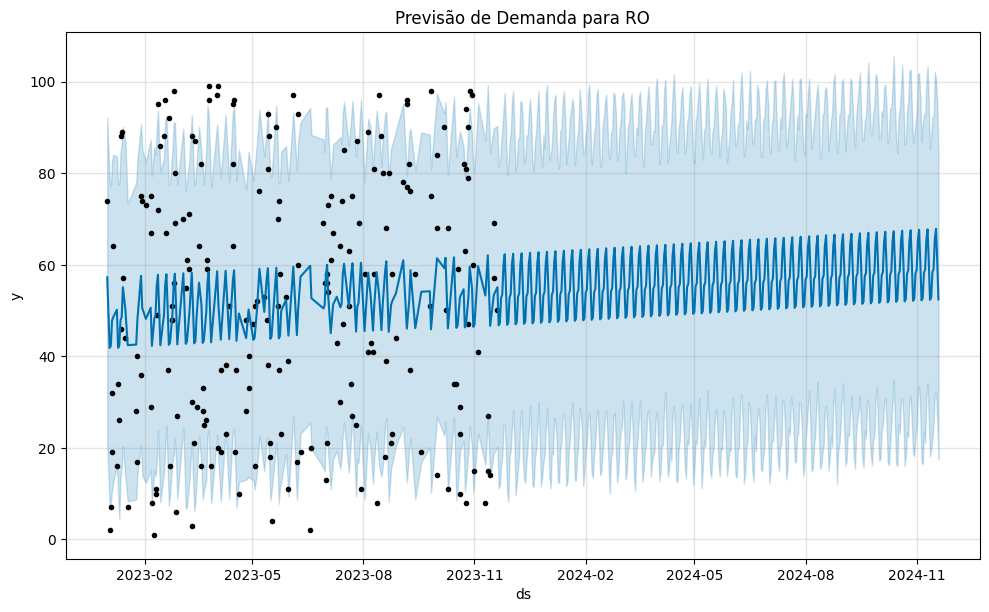

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/oad68uox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/akyq5_y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39304', 'data', 'file=/tmp/tmp6e_lqynu/oad68uox.json', 'init=/tmp/tmp6e_lqynu/akyq5_y0.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelhj9jqtmx/prophet_model-20231208035750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


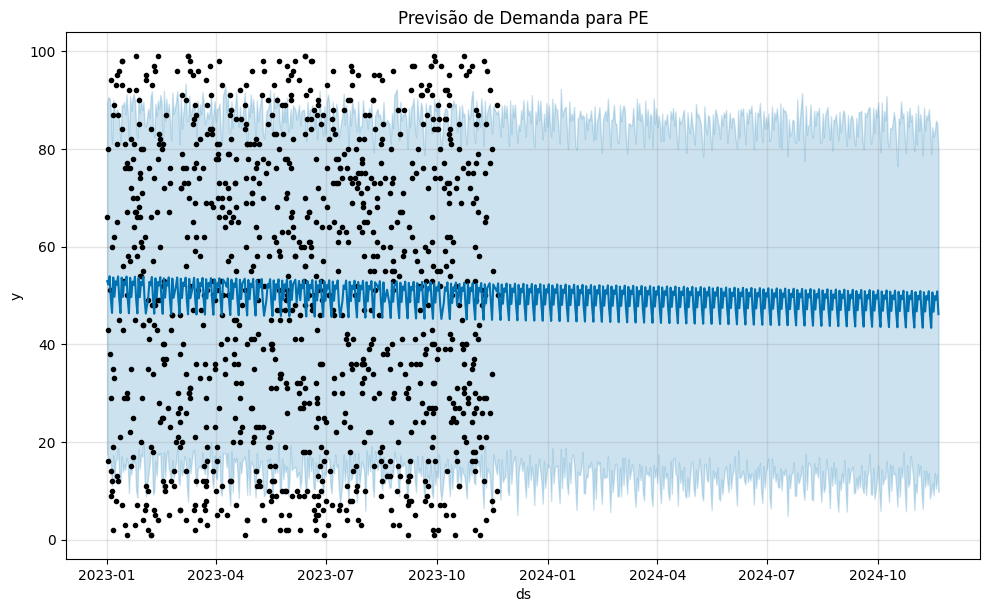

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/_5k709v3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/1x6xi8fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20114', 'data', 'file=/tmp/tmp6e_lqynu/_5k709v3.json', 'init=/tmp/tmp6e_lqynu/1x6xi8fk.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model839w2n_a/prophet_model-20231208035751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


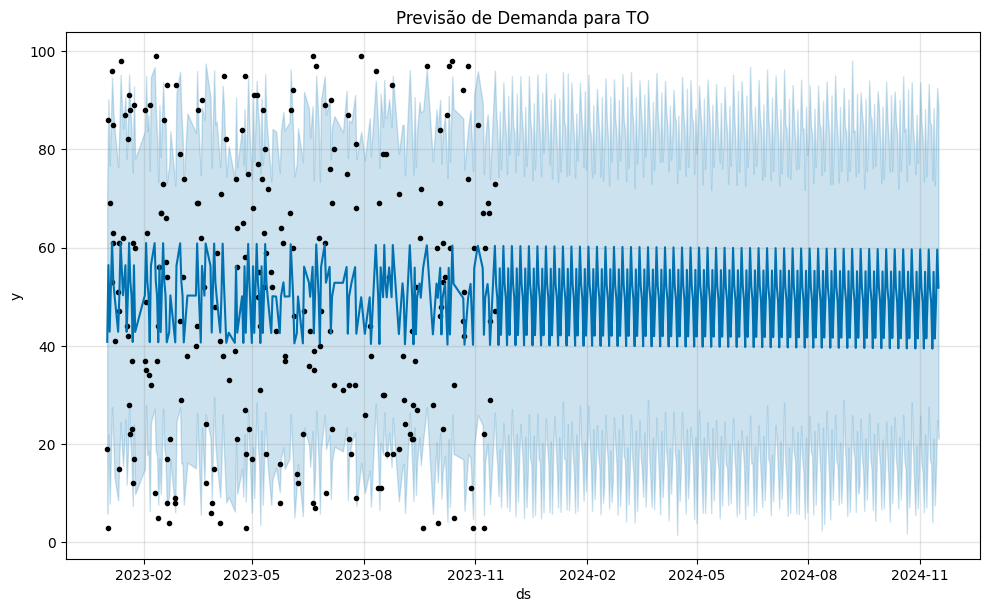

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/8a4_3x9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/qkf8_rzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21791', 'data', 'file=/tmp/tmp6e_lqynu/8a4_3x9i.json', 'init=/tmp/tmp6e_lqynu/qkf8_rzu.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelfbav_shx/prophet_model-20231208035752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


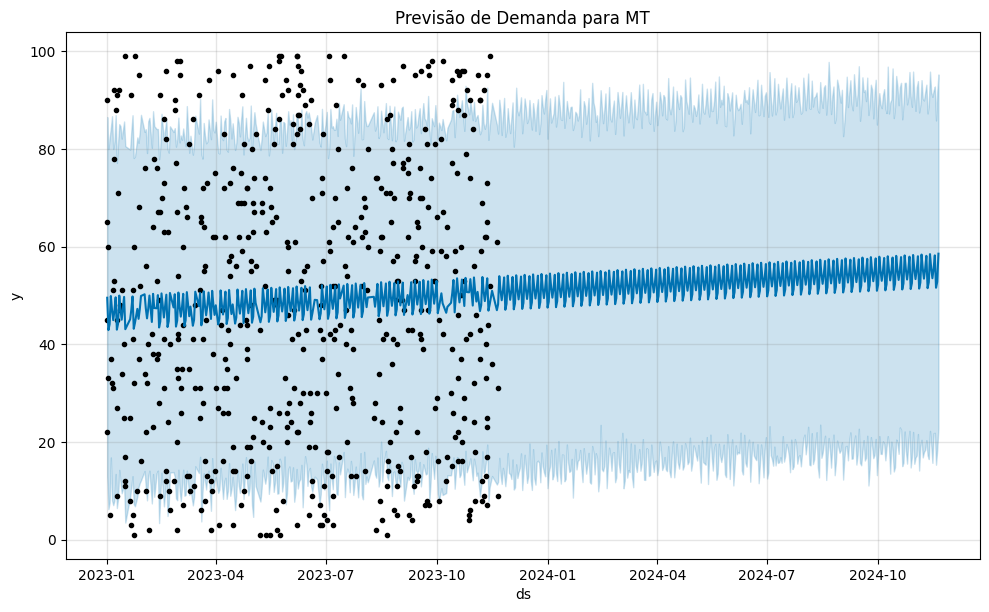

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/8_ut9m2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/rbzxiewh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27873', 'data', 'file=/tmp/tmp6e_lqynu/8_ut9m2f.json', 'init=/tmp/tmp6e_lqynu/rbzxiewh.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model01xb289s/prophet_model-20231208035753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


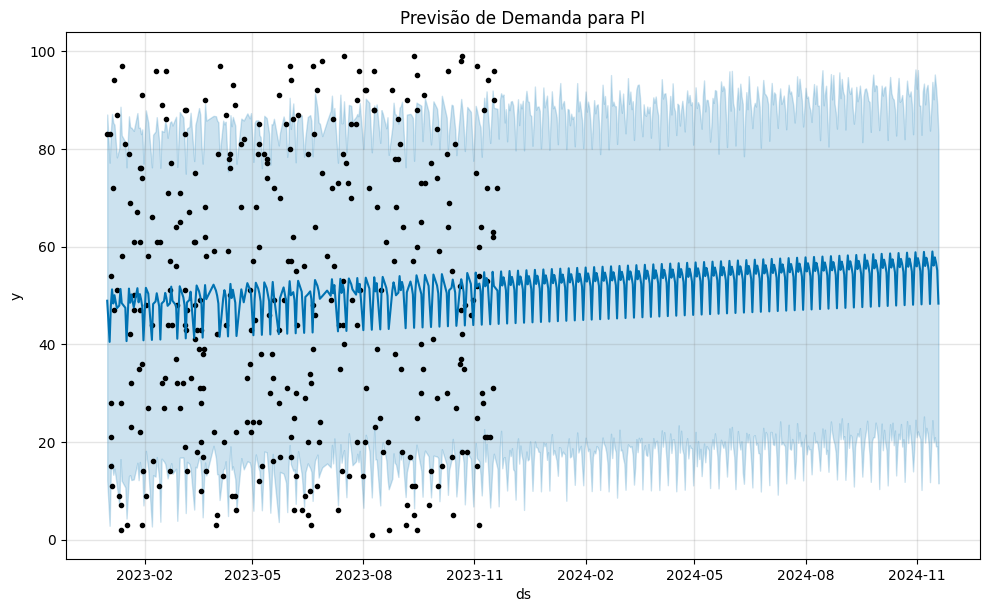

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/f4h12wsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/eao2sc54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58841', 'data', 'file=/tmp/tmp6e_lqynu/f4h12wsi.json', 'init=/tmp/tmp6e_lqynu/eao2sc54.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modeljda1u78q/prophet_model-20231208035754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


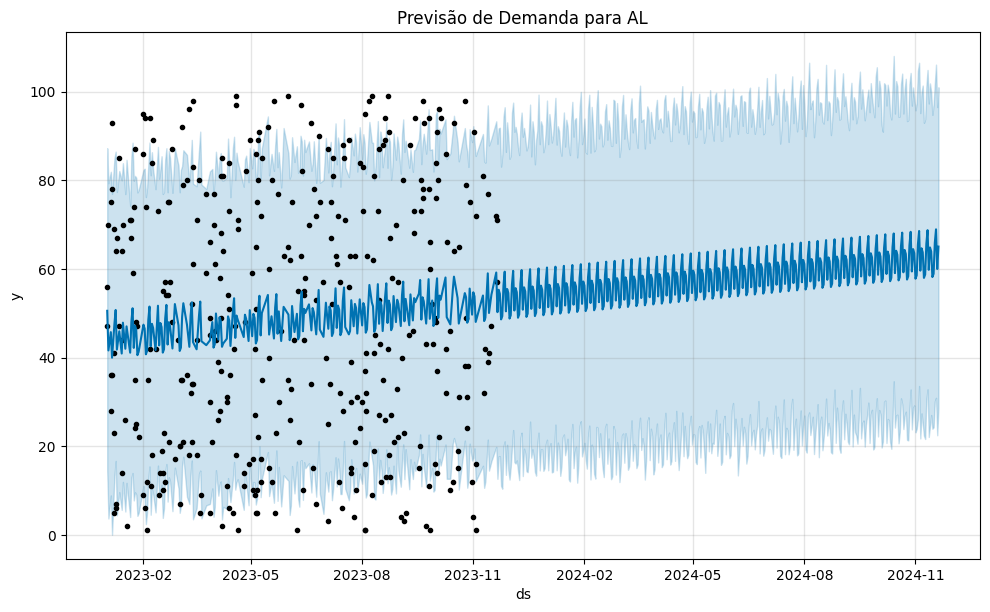

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/wlo7m5u2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/q5qhxy4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22667', 'data', 'file=/tmp/tmp6e_lqynu/wlo7m5u2.json', 'init=/tmp/tmp6e_lqynu/q5qhxy4s.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_model1yhc22l6/prophet_model-20231208035755.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


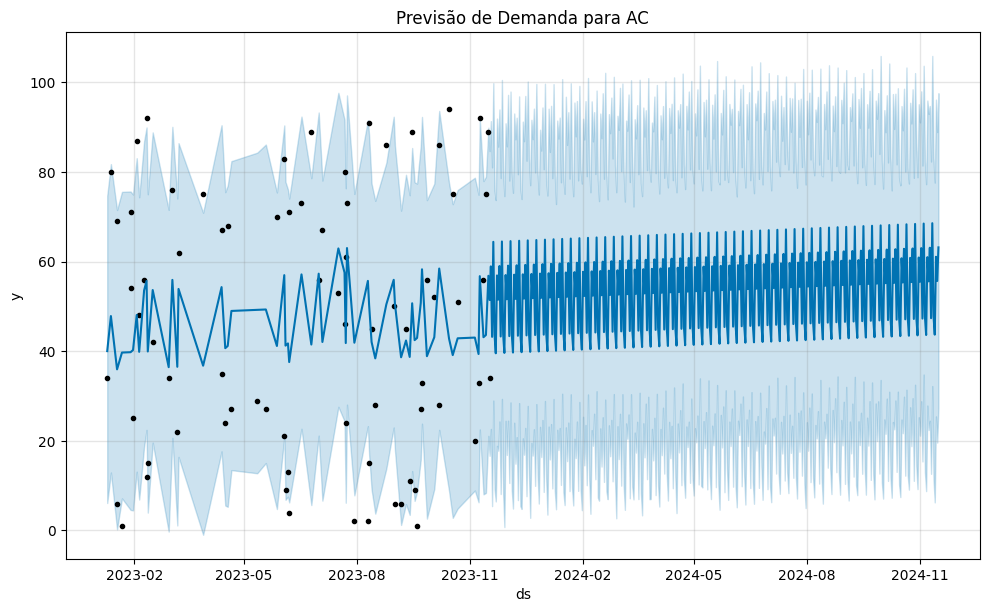

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/6ghle0f4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/tb9h8qk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96508', 'data', 'file=/tmp/tmp6e_lqynu/6ghle0f4.json', 'init=/tmp/tmp6e_lqynu/tb9h8qk2.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelzc7r694_/prophet_model-20231208035756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


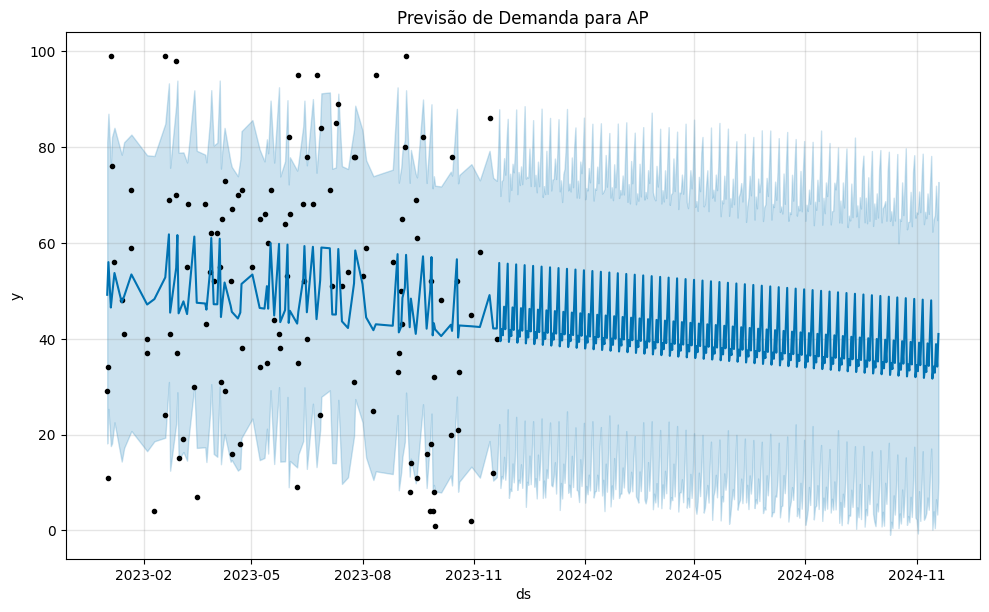

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/dwu32mpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/ydem914r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39819', 'data', 'file=/tmp/tmp6e_lqynu/dwu32mpe.json', 'init=/tmp/tmp6e_lqynu/ydem914r.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modelpxjmjn3y/prophet_model-20231208035758.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


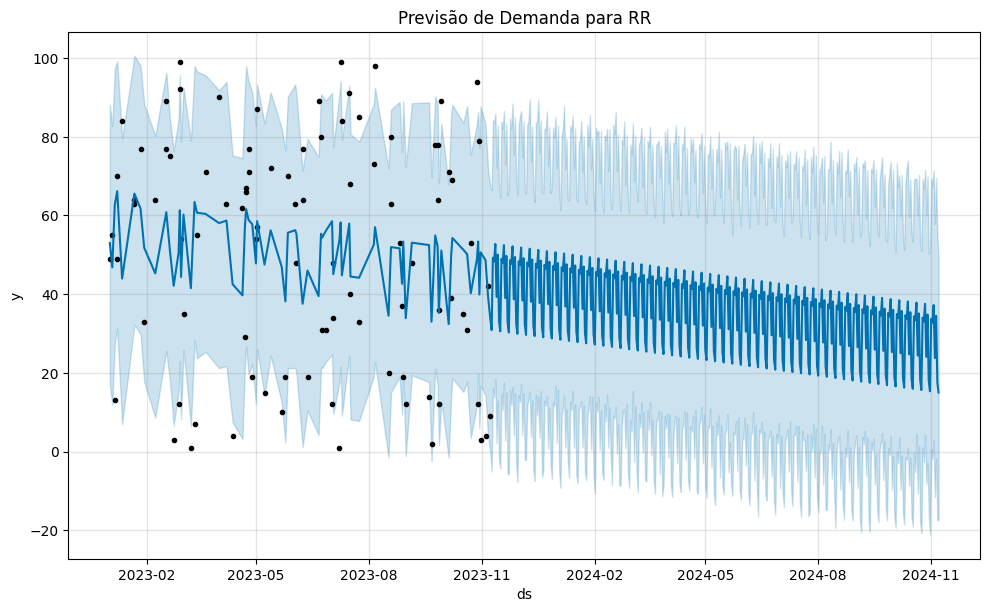

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/k6sopwwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e_lqynu/siww8vy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28167', 'data', 'file=/tmp/tmp6e_lqynu/k6sopwwk.json', 'init=/tmp/tmp6e_lqynu/siww8vy5.json', 'output', 'file=/tmp/tmp6e_lqynu/prophet_modely0lvwhpv/prophet_model-20231208035759.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:59 - cmdstanpy - INFO - Chain [1] start processing
IN

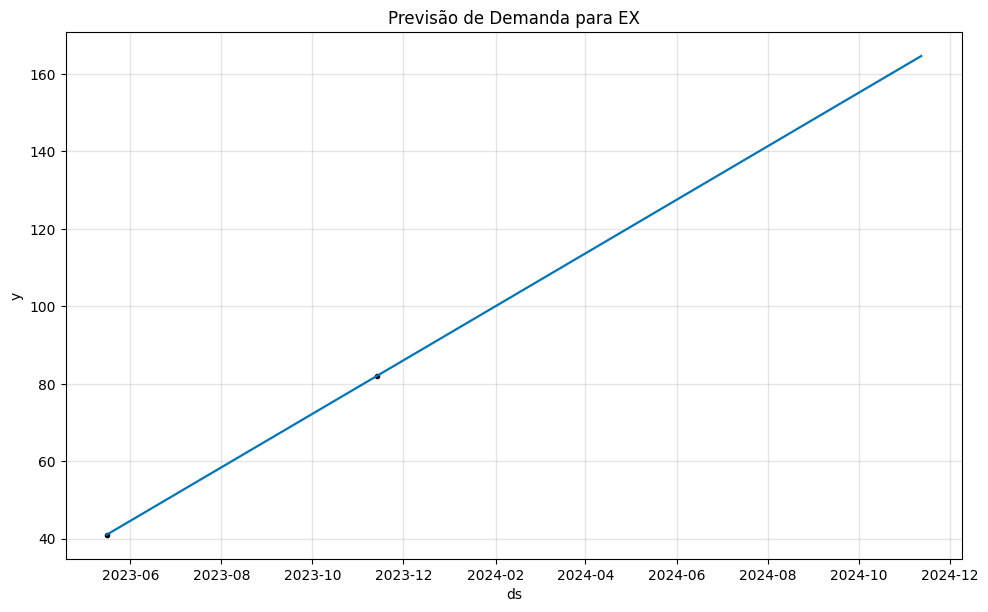

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet # Importar o módulo Prophet do pacote prophet

# Carregar os dados
data = df
data['data'] = pd.to_datetime(data['data'])

# Listar as regiões únicas no conjunto de dados
regioes = data['sigla_uf'].unique()

# Criar e treinar modelos para cada região
for regiao in regioes:
   regiao_data = data[data['sigla_uf'] == regiao]
   regiao_data = regiao_data[['data', 'quantidade']].rename(columns={'data': 'ds', 'quantidade': 'y'})

   # Criar e treinar o modelo
   model = Prophet()
   model.fit(regiao_data)

   # Criar um dataframe para os próximos 365 dias
   future = model.make_future_dataframe(periods=365)
   forecast = model.predict(future)

   # Visualizar a previsão
   fig = model.plot(forecast)
   plt.title(f"Previsão de Demanda para {regiao}")
   plt.show()


#Conclusão
Dado que os dados de venda são fictícios, é impossível obter bons resultados com um modelo de inteligência artificial, já que a relação(coeficiência) entre essas informações não existem e não são compatíveis com o mundo real. Porém, dentro de um sistema de produção com dados verdadeiros e não aleatórios, o modelo pode alcançar resultados muito superiores e oferecer análises mais precisas.